In [1]:
pip install geoplot

Note: you may need to restart the kernel to use updated packages.


In [2]:
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import branca
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point
import pyproj # change between WGS84 and Illimap coordinates
from collections import defaultdict
from datetime import datetime
from folium.plugins import HeatMap, HeatMapWithTime, DualMap

In [3]:
colormap = branca.colormap.linear.RdBu_11.scale(-100, 100)

In [4]:
colormap = colormap.to_step(index=[-100,-50,-40,-30,-20,-10,0,10,20,30,40,50,100])
colormap

In [5]:
# will county shapefile df
# highway shapefile hwy
df = gpd.read_file('Will county/will county shapefile/Will_County.shp')
hwy = gpd.read_file('Will county/highway/HWY_will_illimap.shp')

In [6]:
# Coordinates for each corner of the domain
sw_lat = 41.174519     #41.174519 #41.356272 #41.41 #southwest latitude
sw_long = -88.408339     #-88.408339 #-88.311217 #-88.24 #southwest longitude
ne_lat = 41.934977     #41.934977 #41.701295 #41.73 #northeast latitude
ne_long = -87.64     #-87.318569 #-87.831109 #-88.03 #northeast longitude

In [7]:
# center point of the domain
cen_lat = (sw_lat + ne_lat)/2
cen_long = (sw_long + ne_long)/2

In [8]:
# the center of will county shapefile
# lambert coordinate system
df.geometry.centroid

0    POINT (3415219.904 3065846.619)
dtype: geometry

In [9]:
hwy.head()

,OBJECTID,INVENTORY,BEG_STA,END_STA,AADT,AADT_YR,ACC_CNTL,BLT,CH,CO_ADJ,...,HPMS_SECT,MPO,FREIGHT,MUNI_NAME,TOWNSHIP_N,CNTYTWP,FCNAME,COUNTY_NAM,Shape_Leng,geometry
0,12,099 20353 000000,10.64,10.69,19500.0,2019,0,1,0000,000,...,None,1051,00,Frankfort,FRANKFORT,09906,Other Principal Arterial,WILL,276.100832,"LINESTRING Z (3465859.113 3088940.606 0.000, 3..."
1,42,099 01396 005745,0.00,0.24,0.0,0000,0,5,0000,000,...,None,1051,00,Tinley Park,FRANKFORT,09906,Local Road or Street,WILL,1298.171963,"LINESTRING Z (3450593.598 3106968.180 0.000, 3..."
2,72,099 00129 002663,0.00,0.20,0.0,0000,0,0,0000,000,...,None,1051,00,Homer Glen,HOMER,09908,Local Road or Street,WILL,1046.613974,"LINESTRING Z (3431635.540 3134958.000 0.000, 3..."
3,88,099 20351 000000,15.31,15.40,17600.0,2015,0,1,0000,000,...,None,1051,00,Homer Glen,HOMER,09908,Other Principal Arterial,WILL,489.082007,"LINESTRING Z (3431952.396 3122455.526 0.000, 3..."
4,104,099 83563 000000,0.00,0.06,0.0,0000,0,0,0000,000,...,None,1051,00,0000,PLAINFIELD,09916,Local Road or Street,WILL,335.992107,"LINESTRING Z (3367606.957 3133357.403 0.000, 3..."


In [10]:
df.crs

<Projected CRS: PROJCS["Clarke_1866_Lambert_Conformal_Conic",GEOGC ...>
Name: Clarke_1866_Lambert_Conformal_Conic
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1927
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

In [11]:
# transform clarke 1866 to epsg 4326
df_proj = df.copy()
df_proj = df.to_crs(epsg=4326)
hwy_proj = hwy.copy()
hwy_proj = hwy.to_crs(epsg=4326)

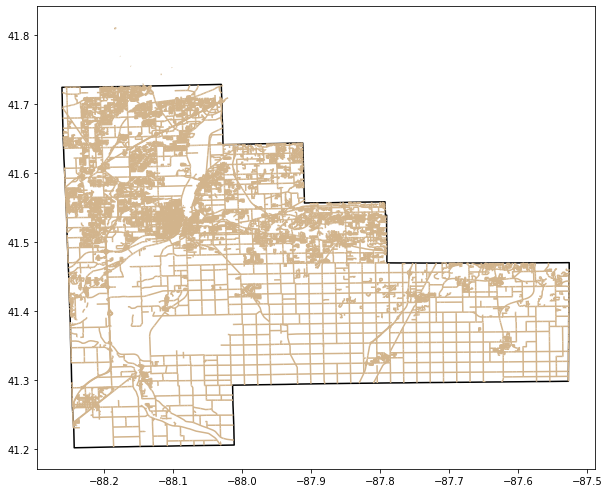

In [12]:
base = df_proj.boundary.plot(figsize=(10,10),color='k')
hwy_proj.plot(ax=base,color='tan')

# View wells distribution and pumpage on an interactive webmap

In [13]:
wells = pd.read_excel('Will county/well data/pumping2002.xlsx')
wells.dropna(how='any',inplace=True)

In [14]:
# preprocessing pumping data naming issues
# merge the well owner, Well number, and pnumber into one cell for the name
# run the following for only one time each try
wells['p_num_str'] = wells['p_num'].apply(lambda x:str(x))
wells['fac_well_num_str'] = wells['fac_well_num'].apply(lambda x:str(x))
wells['well_info'] = wells['owner']+' '+wells['fac_well_num_str']+' '+wells['p_num_str']
wells = wells.drop(['p_num','fac_well_num','p_num_str','fac_well_num_str','owner'],axis=1)

# move the well_info column to be the first column
cols = wells.columns.tolist()
cols = cols[-1:]+cols[:-1]
wells = wells[cols]

In [15]:
wells.head()

,well_info,isws_facility_id,depth_total_last_known,Pumpage 2002 (gal/yr),Longitude,Latitude
0,AQUA ILLINOIS - OAKVIEW 4 411178,19797210.0,305.0,152400000.0,-88.046134,41.518670
1,AQUA ILLINOIS - OAKVIEW 3 409294,19797210.0,257.0,20000000.0,-88.047315,41.518172
2,AQUA ILLINOIS - OAKVIEW 2 409293,19797210.0,200.0,0.0,-88.044801,41.519947
3,BEECHER 3 409179,19790050.0,500.0,41149000.0,-87.603452,41.351988
4,BEECHER 2 409180,19790050.0,230.0,0.0,-87.628680,41.342103


In [16]:
# show model area in folium
model_area = folium.Map(location=[cen_lat,cen_long],zoom_start=10)

# create a group to contain modeling boundary
# draw a GeoDataFrame into folium
bound = folium.FeatureGroup(name='boundary')
bound.add_to(model_area)
folium.GeoJson(df_proj).add_to(bound)

# create a group to contain well sites
well_site = folium.FeatureGroup(name='well sites')
well_site.add_to(model_area)

# add well sites into the group on the map
for i, row in wells.iterrows():
    lon = row['Longitude']; lat = row['Latitude']
    owner = row['well_info']
    well_site.add_child(folium.CircleMarker(location=[lat,lon],
                                           radius=7,color='yellow',fill=True,
                                           fill_color='red',fill_opacity=0.4))
    
    folium.Marker(location=[lat,lon],popup=owner).add_to(well_site)

folium.TileLayer('Stamen Toner').add_to(model_area)
folium.TileLayer('Stamen Terrain').add_to(model_area)

# add a control botton on the top right
folium.LayerControl().add_to(model_area)



model_area

# View error map of pumping head on webmaps

Detailed codes are stored in my branch in shallow_group github page .

In [17]:
%%html
<iframe src='Will county/created_map/will_map.html' width=1000 height=600/>

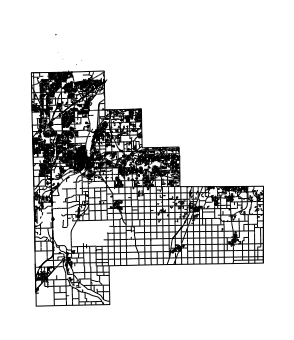

In [18]:
ax = gplt.polyplot(df=df_proj,
                   projection=gcrs.AlbersEqualArea())
ax = gplt.polyplot(df=hwy_proj,
                   ax=ax)

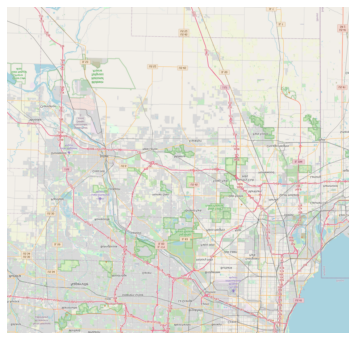

In [19]:
gplt.webmap(df_proj, projection=gcrs.WebMercator())

# Chloride data visualization with heatmap

In [20]:
# read in the chloride data
chlo = pd.read_excel('Will county/chloride/SWPG_Cl_Dec2020.xlsx',sheet_name='edited')

In [21]:
# drop non-needed columns
chlo.drop(columns=['p_num','facility','well_no'],inplace=True)

In [22]:
illimap = {'proj': 'lcc', # code for Lambert Conformal Conic
     'ellps': 'clrk66',
     'lon_0': -89.5,
     'lat_0': 33,
     'lat_1': 33,
     'lat_2': 45,
     'x_0': 2999994*0.3048,
     'y_0': 0}

prj = pyproj.Proj(illimap) #define "prj" as the illimap coordinate system

wgs84 = pyproj.Proj("epsg:4326") #define "wgs84" as the EPSG 4326 / WGS84 coordinate system

# Note that WGS84 and EPSG 4326 are equivalent

# Transform the coordinates of lambert x and y from Illimap to WGS84 (lat and long)
# 0.3048: convert ft to m
lat_list = []
lon_list = []
for i,row in chlo.iterrows():
    lat,lon = pyproj.transform(illimap,wgs84,row['Lambert_x']*0.3048,row['Lambert_y']*0.3048)
    lat_list.append(lat)
    lon_list.append(lon)

chlo['Lat'] = lat_list
chlo['Lon'] = lon_list

In [23]:
chlo.head()

,well_depth,Lambert_x,Lambert_y,date_collected,Cl_ppm,totalname,Lat,Lon
0,300.00,3426290,3120518,1990-04-18,9.4,ILLINOIS AMERICAN - HOMER TWP DIVISION Well 3 ...,41.595135,-87.934461
1,203.00,3352806,3104395,1990-06-28,47.0,SHOREWOOD Well 5 pnum409871,41.553881,-88.205128
2,40.75,3265164,3143766,1990-11-14,24.0,PLANO Well 5 pnum406653,41.665425,-88.525209
3,220.00,3353310,3103466,1991-04-29,184.0,SHOREWOOD Well 6 pnum410184,41.551300,-88.203327
4,305.00,3397774,3091935,1991-07-09,142.0,INGALLS PARK SUBD Well 2 pnum409282,41.517655,-88.040850


In [24]:
# create a geometry column
geometry = [Point(xy) for xy in zip(chlo['Lat'],chlo['Lon'])]
chlo_gdf = gpd.GeoDataFrame(chlo,geometry=geometry,crs=4326)
chlo_gdf.drop(columns=['Lambert_x','Lambert_y'],inplace=True)

In [25]:
chlo_gdf

,well_depth,date_collected,Cl_ppm,totalname,Lat,Lon,geometry
0,300.00,1990-04-18,9.4,ILLINOIS AMERICAN - HOMER TWP DIVISION Well 3 ...,41.595135,-87.934461,POINT (41.59514 -87.93446)
1,203.00,1990-06-28,47.0,SHOREWOOD Well 5 pnum409871,41.553881,-88.205128,POINT (41.55388 -88.20513)
2,40.75,1990-11-14,24.0,PLANO Well 5 pnum406653,41.665425,-88.525209,POINT (41.66542 -88.52521)
3,220.00,1991-04-29,184.0,SHOREWOOD Well 6 pnum410184,41.551300,-88.203327,POINT (41.55130 -88.20333)
4,305.00,1991-07-09,142.0,INGALLS PARK SUBD Well 2 pnum409282,41.517655,-88.040850,POINT (41.51765 -88.04085)
...,...,...,...,...,...,...,...
220,160.00,2018-11-14,247.0,ROMEOVILLE Well 3 pnum409450,41.646382,-88.098372,POINT (41.64638 -88.09837)
221,203.00,2019-02-05,83.9,SHOREWOOD Well 5 pnum409871,41.553881,-88.205128,POINT (41.55388 -88.20513)
222,203.00,2020-03-03,98.0,SHOREWOOD Well 5 pnum409871,41.553881,-88.205128,POINT (41.55388 -88.20513)
223,220.00,2020-03-03,82.0,SHOREWOOD Well 6 pnum410184,41.556544,-88.203613,POINT (41.55654 -88.20361)


In [26]:
# plot the heatmap
from folium.plugins import HeatMap
data = chlo_gdf[['Lat','Lon','Cl_ppm']].values.tolist()
hmap = folium.Map(location=[chlo_gdf['Lat'].mean(),chlo_gdf['Lon'].mean()], tiles='stamentoner',
                  control_scale=True, zoom_start=11)
hmap.add_child(HeatMap(data, radius=15, gradient={.25: 'lightcoral', .5: 'indianred', .75: 'red', 1: 'firebrick'}))

In [27]:
# heatmap with time
# chloride concentration data changes over time (year)
cl_set = defaultdict(list)
for i, row in chlo_gdf.iterrows():
    year = int(row['date_collected'].strftime('%Y'))
    lat = row['Lat']; lon = row['Lon']
    cl= row['Cl_ppm']
    cl_set[year].append([lat,lon,cl])

In [28]:
cl_year = list(dict(cl_set).values())
year_index = list(dict(cl_set).keys())
hmap = folium.Map(location=[chlo_gdf['Lat'].mean(),chlo_gdf['Lon'].mean()], tiles='stamentoner',zoom_start=11)
cl_time = HeatMapWithTime(cl_year,radius=15,index=year_index,auto_play=True,
                              gradient={.25: 'lightcoral', .5: 'indianred', .75: 'red', 1: 'firebrick'})
cl_time.add_to(hmap)

hmap

In [29]:
years = []
for i, row in chlo_gdf.iterrows():
    year = int(row['date_collected'].strftime('%Y'))
    years.append(year)
chlo_gdf['year_collected'] = years

cl_data1 = []
for i in range(1990,2021):
    cl_data2 = []
    cl_data1.append(cl_data2)

    for index, row in chlo_gdf[chlo_gdf['year_collected']<=i].iterrows():
        cl_set = [row['Lat'],row['Lon'],row['Cl_ppm']]
        cl_data2.append(cl_set)

In [30]:
year_index = list(range(1990,2021))
hmap = folium.Map(location=[chlo_gdf['Lat'].mean(),chlo_gdf['Lon'].mean()], tiles='stamentoner',zoom_start=11)
cl_time = HeatMapWithTime(cl_data1,radius=20,index=year_index,auto_play=True,
                              gradient={.25: 'lightcoral', .5: 'indianred', .75: 'red', 1: 'firebrick'})
cl_time.add_to(hmap)

hmap

In [31]:
# DualMap
m = DualMap(location=[cen_lat,cen_long],zoom_start=9,tiles=None)

folium.TileLayer('stamentoner').add_to(m.m1)
folium.TileLayer('cartodbpositron').add_to(m.m2)
folium.TileLayer("openstreetmap").add_to(m)

fg_1 = folium.FeatureGroup(name="chloride concentration in 2020").add_to(m.m1)
# fg_2 = folium.FeatureGroup(name='Time series of chloride concentration').add_to(m.m2)

well_site = folium.FeatureGroup(name='well sites')
well_site.add_to(m)

# add well sites into the group on the map
for i, row in chlo_gdf.iterrows():
    lon = row['Lon']; lat = row['Lat']
    owner = row['totalname']
    well_site.add_child(folium.CircleMarker(location=[lat,lon],
                                           radius=7,color='yellow',fill=True,
                                           fill_color='red',fill_opacity=0.4))
    
    folium.Marker(location=[lat,lon],popup=owner).add_to(well_site)
    
data = chlo_gdf[['Lat','Lon','Cl_ppm']].values.tolist()
HeatMap(data, radius=15, gradient={.25: 'lightcoral', .5: 'indianred', .75: 'red', 1: 'firebrick'}).add_to(fg_1)

HeatMapWithTime(cl_data1,radius=20,index=year_index,
                              gradient={.25: 'lightcoral', .5: 'indianred', .75: 'red', 1: 'firebrick'}).add_to(m.m2)

folium.LayerControl().add_to(m)

m.save('Will county/created_map/chloride map.html')
m

In [32]:
int(chlo_gdf['date_collected'][0].strftime("%Y"))

1990